# MLPClassifier miRNA
Runs sklearn's [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) on miRNA data.  

Three datasets are analyzed using the RandomForest classifier:
* Sham and infeceted mice from all weeks; i.e., 8 week and 16 week datasets are merged.
* Sham and infected mice at 8 weeks.
* Sham and infected mice at 16 weeks.

In each dataset, there is a flag (named ‘infected’) that marks whether the mice came from the infected group or the sham group.  
RandomForestClassifier's variable importance and SHAP values are then used to determine which miRNA variable was most important in each cohort dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# trying to supress sklearn warning
import os
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import \
    RandomizedSearchCV, GridSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import \
    accuracy_score, f1_score, recall_score, classification_report, \
    roc_auc_score, roc_curve, mean_absolute_error
from IPython.display import display
import random
import shap

from util import \
    make_mirna_nanostring_df, make_study_df, param_search_cv, \
    param_search, plot_shap_feature_importance, plot_xgb_feature_importance, \
    combine_shap_heatmaps, plot_shap_summary, plot_shap_heatmap, \
    plot_shap_dependence, plot_shap_importance_with_summary, top_shap_values

In [4]:
! python --version

Python 3.11.6


In [5]:
print('sklearn version', sklearn.__version__)
print('shap version', shap.__version__)

sklearn version 1.3.0
shap version 0.42.1


---

## load miRNA data

In [6]:
file_names = [
    '../data/Streptococcus_gordonii/8 weeks S.gordonii infection.csv', 
    '../data/Streptococcus_gordonii/8 weeks SHAM infection.csv', 
    '../data/Streptococcus_gordonii/16 weeks S. gordonii infection.csv', 
    '../data/Streptococcus_gordonii/16 weeks SHAM infection.csv'
]
cohort_names = ['sg_8_weeks', 'sham_8_weeks', 'sg_16_weeks', 'sham_16_weeks']
list(zip(file_names, cohort_names))

[('../data/Streptococcus_gordonii/8 weeks S.gordonii infection.csv',
  'sg_8_weeks'),
 ('../data/Streptococcus_gordonii/8 weeks SHAM infection.csv', 'sham_8_weeks'),
 ('../data/Streptococcus_gordonii/16 weeks S. gordonii infection.csv',
  'sg_16_weeks'),
 ('../data/Streptococcus_gordonii/16 weeks SHAM infection.csv',
  'sham_16_weeks')]

In [7]:
miRNA_df = make_mirna_nanostring_df(file_names, cohort_names)
miRNA_df.shape

(40, 604)

## create dataframes and X, y datasets

In [8]:
df_8_weeks = make_study_df(miRNA_df, cohort_str='8_weeks', infected_str='sg_')
df_16_weeks = make_study_df(miRNA_df, cohort_str='16_weeks', infected_str='sg_')
df_all_weeks = make_study_df(miRNA_df, infected_str='sg_')

In [9]:
X_8_weeks, y_8_weeks = df_8_weeks.drop('infected', axis=1), df_8_weeks['infected']
X_16_weeks, y_16_weeks = df_16_weeks.drop('infected', axis=1), df_16_weeks['infected']
X_all_weeks, y_all_weeks = df_all_weeks.drop('infected', axis=1), df_all_weeks['infected']

---

## search for best params

In [10]:
# see https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b
random_grid = {
    'hidden_layer_sizes': [(256, 128), (300, 150), (400, 200)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.01, 0.001, 0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive', 'invscaling']
}

In [11]:
# used for testing single param search
# params_8_weeks = \
#     param_search(random_grid, X_8_weeks, y_8_weeks, MLPClassifier, cv=5)

### this code block takes a while to run, uncomment to run it
Note: GridSearchCV takes too long to compute. So, RandomizedSearchCV is used.

In [12]:
# cv_range = [3, 5, 10]
# clf = MLPClassifier

# print('** 8 weeks params **')
# params_8_weeks_cv = \
#     param_search_cv(
#         random_grid, X_8_weeks, y_8_weeks, clf, cvs=cv_range, print_best=True)

# print('** 16 weeks params **')
# params_16_weeks_cv = \
#     param_search_cv(
#         random_grid, X_16_weeks, y_16_weeks, clf, cvs=cv_range, print_best=True)

# print('** All weeks params **')
# params_8_weeks_cv = \
#     param_search_cv(
#         random_grid, X_all_weeks, y_all_weeks, clf, cvs=cv_range, print_best=True)

### assign best params

In [13]:
params_8_weeks = \
    {
        'activation': 'relu',
        'alpha': 0.01,
        'hidden_layer_sizes': (256, 128),
        'learning_rate': 'adaptive',
        'solver': 'adam'
    }
 
params_16_weeks = \
    {
        'activation': 'relu',
        'alpha': 0.01,
        'hidden_layer_sizes': (400, 200),
        'learning_rate': 'constant',
        'solver': 'adam'
    }

params_all_weeks = \
    {
        'activation': 'relu',
        'alpha': 0.01,
        'hidden_layer_sizes': (400, 200),
        'learning_rate': 'constant',
        'solver': 'adam'
    }

---

### compute RF Forest models

In [14]:
model_8_weeks = MLPClassifier(**params_8_weeks).fit(X_8_weeks, y_8_weeks)
model_16_weeks = MLPClassifier(**params_16_weeks).fit(X_16_weeks, y_16_weeks)
model_all_weeks = MLPClassifier(**params_all_weeks).fit(X_all_weeks, y_all_weeks)

In [15]:
print ('model_8_weeks', 'f1 score:', f1_score(y_8_weeks, model_8_weeks.predict(X_8_weeks)))
print ('model_16_weeks', 'f1 score:', f1_score(y_16_weeks, model_16_weeks.predict(X_16_weeks)))
print ('model_all_weeks', 'f1 score:', f1_score(y_all_weeks, model_all_weeks.predict(X_all_weeks)))

model_8_weeks f1 score: 1.0
model_16_weeks f1 score: 1.0
model_all_weeks f1 score: 1.0


---

### compute SHAP values (used for explainablity)

In [16]:
# need to change int and bool to classes int_ and bool_ to handle error 'numpy' has no attribute 'int'/'bool'/etc.
np.bool = np.bool_
np.int = np.int_
np.float = np.float_

In [17]:
explainer_8_weeks = shap.KernelExplainer(
    model_8_weeks.predict, X_8_weeks, feature_names=X_8_weeks.columns.tolist()
)
shap_values_8_weeks = explainer_8_weeks(X_8_weeks)

explainer_16_weeks = shap.KernelExplainer(
    model_16_weeks.predict, X_16_weeks, feature_names=X_16_weeks.columns.tolist()
)
shap_values_16_weeks = explainer_16_weeks(X_16_weeks)

explainer_all_weeks = shap.KernelExplainer(
    model_all_weeks.predict, X_all_weeks, feature_names=X_all_weeks.columns.tolist()
)
shap_values_all_weeks = explainer_all_weeks(X_all_weeks)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

---

## Bar and summary plots of feature importance

In [18]:
# shap_values_8_weeks

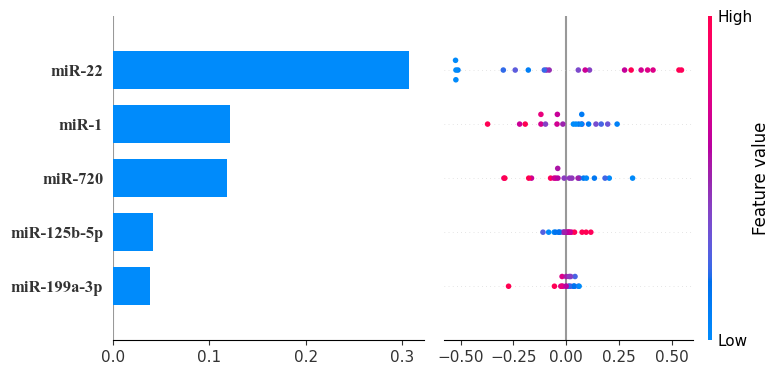

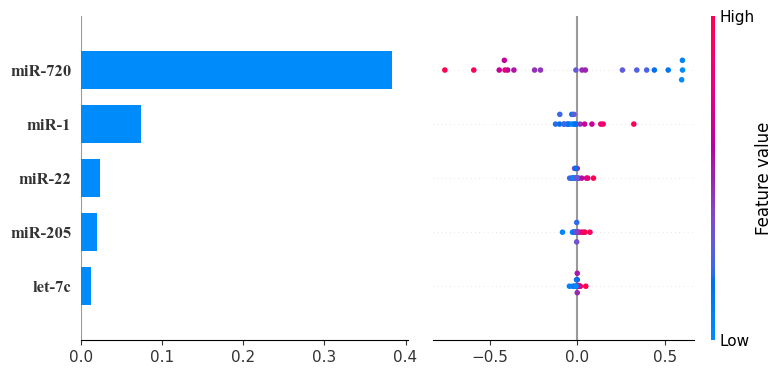

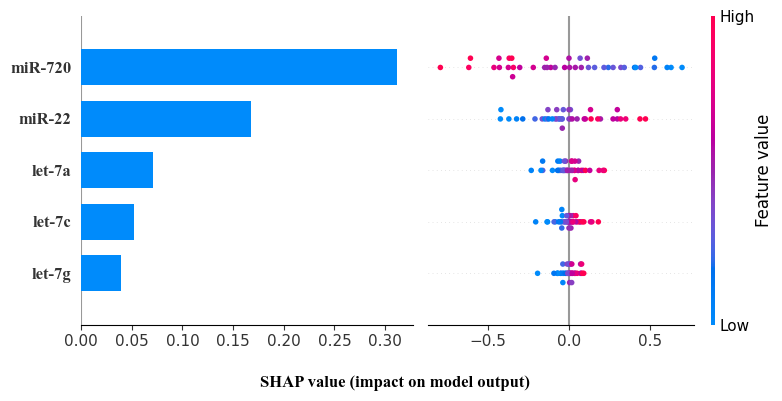

In [19]:
plot_shap_importance_with_summary(
    shap_values_8_weeks, 
    X_8_weeks, 
    title='',
    save_fig=True,
    file_name='sg_mlp_SHAP_feature_importance_with_summary_8_weeks.png'
)

plot_shap_importance_with_summary(
    shap_values_16_weeks, 
    X_16_weeks, 
    title='',
    save_fig=True,
    file_name='sg_mlp_SHAP_feature_importance_with_summary_16_weeks.png'
)

plot_shap_importance_with_summary(
    shap_values_all_weeks, 
    X_all_weeks, 
    title='',
    supxlabel = 'SHAP value (impact on model output)',
    save_fig=True,
    file_name='sg_mlp_SHAP_feature_importance_with_summary_all_weeks.png'
)

## SHAP heatmaps

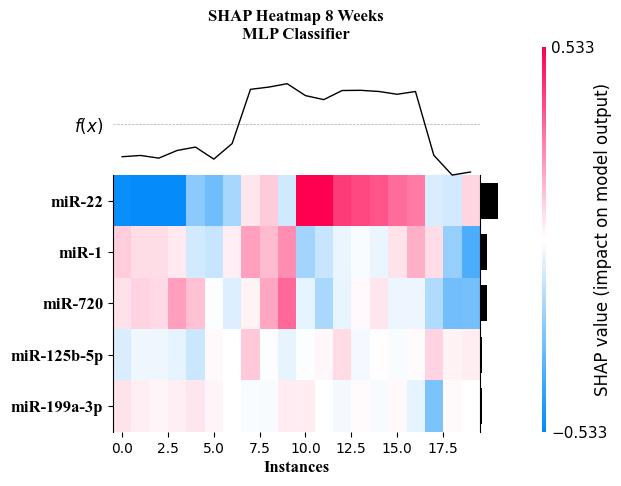

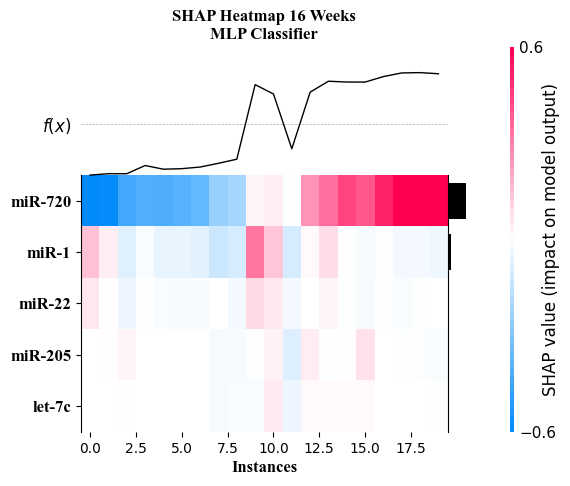

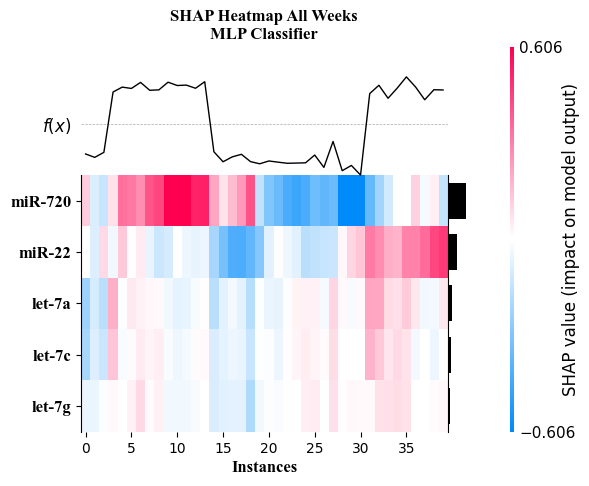

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
plot_shap_heatmap(
    top_shap_values(shap_values_8_weeks), 
    "SHAP Heatmap 8 Weeks\nMLP Classifier", 
    x_label='Instances',
    save_fig=True,
    file_name='sg_mlp_SHAP_Heatmap_8_Weeks.png'
)

plot_shap_heatmap(
    top_shap_values(shap_values_16_weeks), 
    "SHAP Heatmap 16 Weeks\nMLP Classifier", 
    x_label='Instances',
    save_fig=True,
    file_name='sg_mlp_SHAP_Heatmap_16_Weeks.png'
)

plot_shap_heatmap(
    top_shap_values(shap_values_all_weeks), 
    "SHAP Heatmap All Weeks\nMLP Classifier", 
    x_label='Instances',
    save_fig=True,
    file_name='sg_mlp_SHAP_Heatmap_All_Weeks.png'
)

## SHAP dependence plots

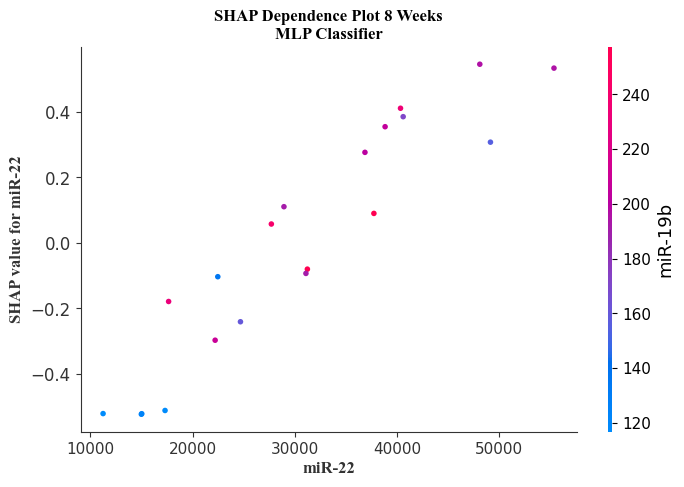

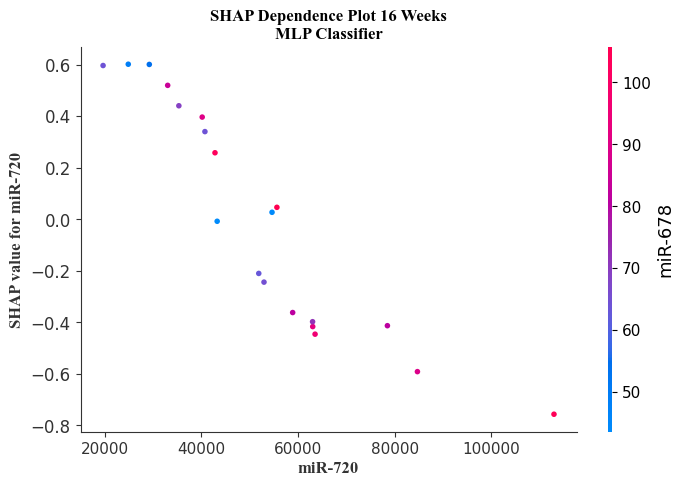

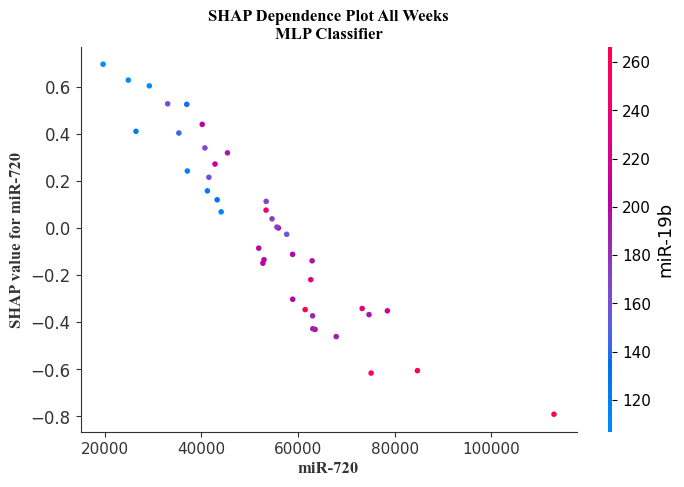

In [21]:
plot_shap_dependence(
    shap_values_8_weeks, 
    X_8_weeks, 
    "SHAP Dependence Plot 8 Weeks\nMLP Classifier", 
    save_fig=True,
    file_name='sg_mlp_SHAP_Dependence_Plot_8_Weeks.png'
)

plot_shap_dependence(
    shap_values_16_weeks, 
    X_16_weeks, 
    "SHAP Dependence Plot 16 Weeks\nMLP Classifier", 
    save_fig=True,
    file_name='sg_mlp_SHAP_Dependence_Plot_16_Weeks.png'
)

plot_shap_dependence(
    shap_values_all_weeks, 
    X_all_weeks, 
    "SHAP Dependence Plot All Weeks\nMLP Classifier", 
    save_fig=True,
    file_name='sg_mlp_SHAP_Dependence_Plot_All_Weeks.png'
)